In [11]:
from os.path import join
import scipy
import numpy as np
import pandas as pd
import networkx as nx
import graph_tool.all as gt
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

import wcorr as wc
from clustering import sponge_partition
import viz_utils as viz

pd.DataFrame.wcorr = wc.wcorr

# settings
wd = join('..', '..', 'data')  # path to where data is kept and results will be saved
metric = 'spearman'            # Spearman or Pearson correlation (leave as Spearman)
measure_str = 'Likelihood'      # whether to load Likelihood or Potential


df = pd.read_csv(join(wd, 'feb_farm_data_s2.csv'))

## Contents
1. Format data
2. Calculate and plot all metrics
3. Calculate network communities

### 1. Format data

In [12]:
# create a dictionary of the criteria names and indices
criteria_df = df.head(10)[['Criterion.1', 'Unnamed: 7']].set_index('Criterion.1')
criteria_df.index.name = 'index'
criteria_df.columns = ['criterion']

# We will use these dictionaries throughout
criteria_dict = {int(val): name for val, name in zip(criteria_df.index, criteria_df['criterion'])}
C = len(criteria_dict)
criteria = [*criteria_dict.values()]
index_dict = {key: value for key, value in zip(range(C), criteria)}

# set up dataframe for each of likelihood, potential, and uncertainty
measure = df.pivot(index="Fish ID", columns="Criterion", values=measure_str)
certainty = df.pivot(index="Fish ID", columns="Criterion", values="Certainty")

# export pivoted dataframes as csvs
measure.to_csv(join(wd, f'{measure_str.lower()}.csv'))
certainty.to_csv(join(wd, 'certainty.csv'))

# have a look at what values are here
measure_unique = [*set(measure.values.ravel())]
print(f"Unique values in {measure_str}: {measure_unique}")
print(f"Unique values in Certainty: {set(certainty.values.ravel())}")

# get rid of negative values and minmax scale option
measure = measure.applymap(lambda x: np.nan if x < 0 else x)
certainty = certainty.applymap(lambda x: np.nan if x < 0 else x)
measure_z = measure / measure.max().max()  # minmax scale to [0, 1]

measure_unique = set(pd.unique(measure.values.ravel('K')))
measurez_unique = set(pd.unique(measure_z.values.ravel('K')))

# look at what unique values exist in dataframe
print(f"\nUnique values in {measure_str} after removing NaNs: {measure_unique}")
print(f"Unique values in {measure_str} after MinMax scaling: {measurez_unique}")

Unique values in Likelihood: [0, 2, -1, -2]
Unique values in Certainty: {0, 1, 2, -2}

Unique values in Likelihood after removing NaNs: {0.0, 2.0, nan}
Unique values in Likelihood after MinMax scaling: {0.0, nan, 1.0}


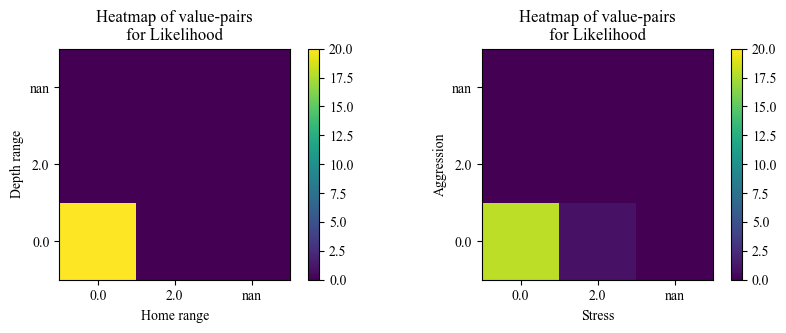

In [13]:
# inspect a single pair of criteria
i, j = 'Home range', 'Depth range'
m, n = 'Stress', 'Aggression'

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
viz.plot_heatmap(measure, i, j, measure_unique, axs[0], measure_str, criteria_dict)
viz.plot_heatmap(measure, m, n, measure_unique, axs[1], measure_str, criteria_dict);

/Users/alison/Documents/FishEtho/fishetho_networks/python/wcorr.py:184: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denom


Spearman correlation of Reproduction and Substrate: 0.37
Weighted Spearman correlation of Reproduction and Substrate: 0.32


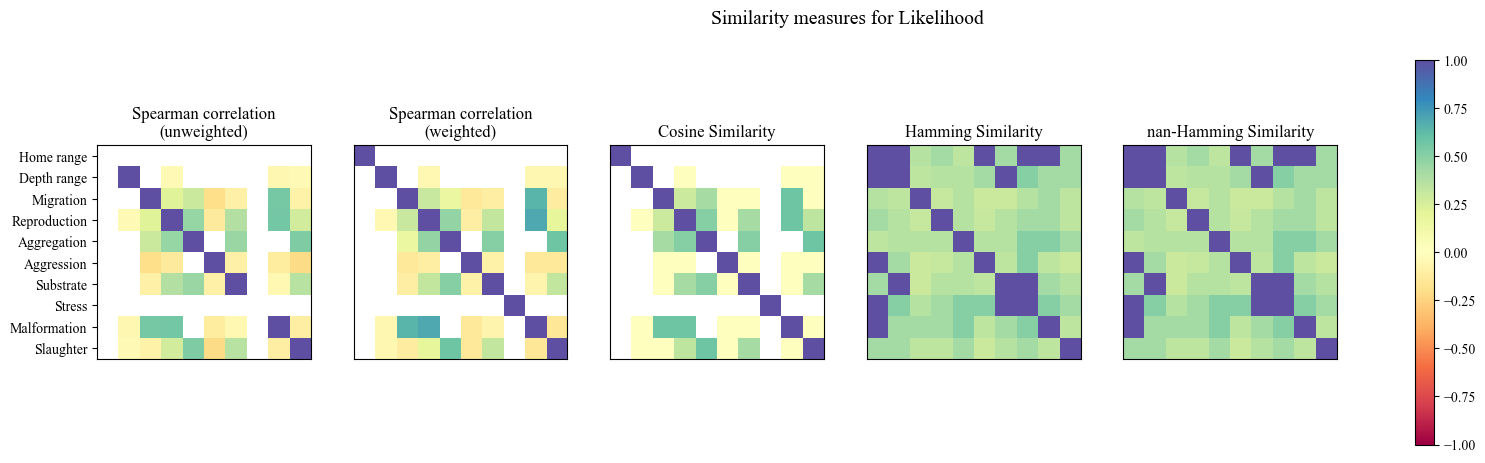

In [14]:
# plot correlation coefficients
cmap = 'Spectral'
spearman_measure = measure.corr(method=metric)
wspearman_measure = measure.wcorr(certainty, method=metric.capitalize())
cosine_measure = measure.corr(method=wc.cosine_similarity)
hamming_measure = measure_z.corr(method=wc.hamming_similarity)
nanhamming_measure = measure_z.corr(method=wc.nanhamming_similarity)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

ax = axs[0]
im = ax.imshow(spearman_measure.to_numpy(), cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Spearman correlation\n(unweighted)')
ax.set_xticks([])
ax.set_yticks([*range(10)])
ax.set_yticklabels([*criteria_dict.values()], rotation=0)

ax = axs[1]
im = ax.imshow(wspearman_measure.to_numpy(), cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Spearman correlation\n(weighted)')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([], rotation=0)


ax = axs[2]
im = ax.imshow(cosine_measure.to_numpy(), cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([])
ax.set_yticks([])

ax = axs[3]
im = ax.imshow(hamming_measure, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Hamming Similarity')
ax.set_xticks([])
ax.set_yticks([])

ax = axs[4]
im = ax.imshow(nanhamming_measure, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('nan-Hamming Similarity')
ax.set_xticks([])
ax.set_yticks([])

fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle(f"Similarity measures for {measure_str}", fontsize=14);

fig.savefig(join(wd, metric, measure_str, f'{measure_str.lower()}.png'), dpi=400)

print(f"Spearman correlation of Reproduction and Substrate: {spearman_measure.loc[30, 33]:.2f}")
print(f"Weighted Spearman correlation of Reproduction and Substrate: {wspearman_measure.loc[30, 33]:.2f}")

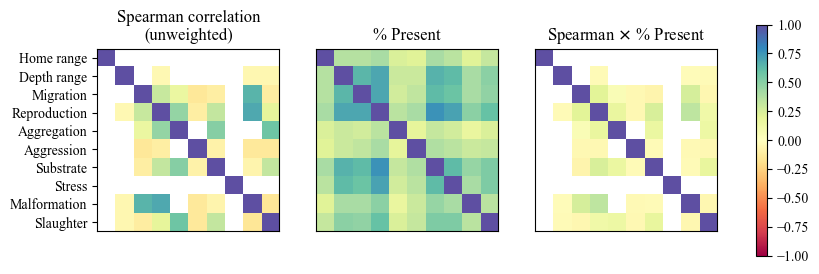

In [15]:
def perc_present(col1, col2, T=len(measure)):
    """View %data present in each pair of columns."""
    valid = np.isfinite(col1) & np.isfinite(col2)
    P = sum(valid)
    return P / T


fig, axs = plt.subplots(1, 3, figsize=(10, 3))

ax = axs[0]
im = ax.imshow(wspearman_measure, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Spearman correlation\n(unweighted)')
ax.set_xticks([])
ax.set_yticks([*range(10)])
ax.set_yticklabels([*criteria_dict.values()], rotation=0)

ax = axs[1]
perc_present = measure.corr(method=perc_present)
ax.imshow(perc_present, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('% Present')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])

ax = axs[2]
prod = wspearman_measure * perc_present
ax.imshow(prod, cmap=cmap, vmin=-1, vmax=1)
ax.set_title(r'Spearman $\times$ % Present')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])

plt.colorbar(im, ax=axs.ravel().tolist());

fig.savefig(join(wd, metric, measure_str, f'{measure_str.lower()}_percpresent.png'), dpi=400)

# Make network

In [16]:
corrs = wspearman_measure.copy(deep=True)
metric = 'spearman'

# Get the upper-triangular indices
triu_indices = np.triu_indices(C, k=1)

# Get the values from the dataframes
corr_values = corrs.values[triu_indices]
present_values = perc_present.values[triu_indices]

# Compute the weights
weights = {}
for k in range(len(corr_values)):
    i, j = triu_indices[0][k], triu_indices[1][k]
    corr = corr_values[k]
    present = present_values[k]
    if not np.isnan(corr):
        weights[(i, j)] = corr * present

# define edge weights using a dict
nodes = [x for x in range(len(corrs))]
edges = {(tup[0], tup[1], weight, np.sign(weight), 10 * abs(weight)) for tup, weight in weights.items()}  # set

# create a networkx Graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from([(edge[0], edge[1], edge[2]) for edge in edges])

A = nx.adjacency_matrix(G).todense()
np.savetxt(join(wd, metric, measure_str.lower(), 'adjacency_weighted.csv'), A, delimiter=",")

# calculate partition using the SPONGE method
community_dict = sponge_partition(G, 3)

/Users/alison/miniconda3/envs/fishethobase_test/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
edgewidth = 1

# create a graph_tool Graph
g = gt.Graph(directed=False)
weight = g.new_ep("double")
absweight = g.new_ep("double")
sign = g.new_ep("double")

# add edge attributes
g.add_edge_list(edges, eprops=[weight, sign, absweight])
g.ep['weight'] = weight

# add vertex properties
name = g.new_vp("string") 
community = g.new_vp('int')
plot_color = g.new_vp('vector<double>')

#set the value to the vertex property
for node in range(C):
    name[node] = index_dict[node]
    community[node] = community_dict[node]

#assign properties as a dict value
g.vertex_properties["name"] = name 
g.vertex_properties['plot_color'] = plot_color

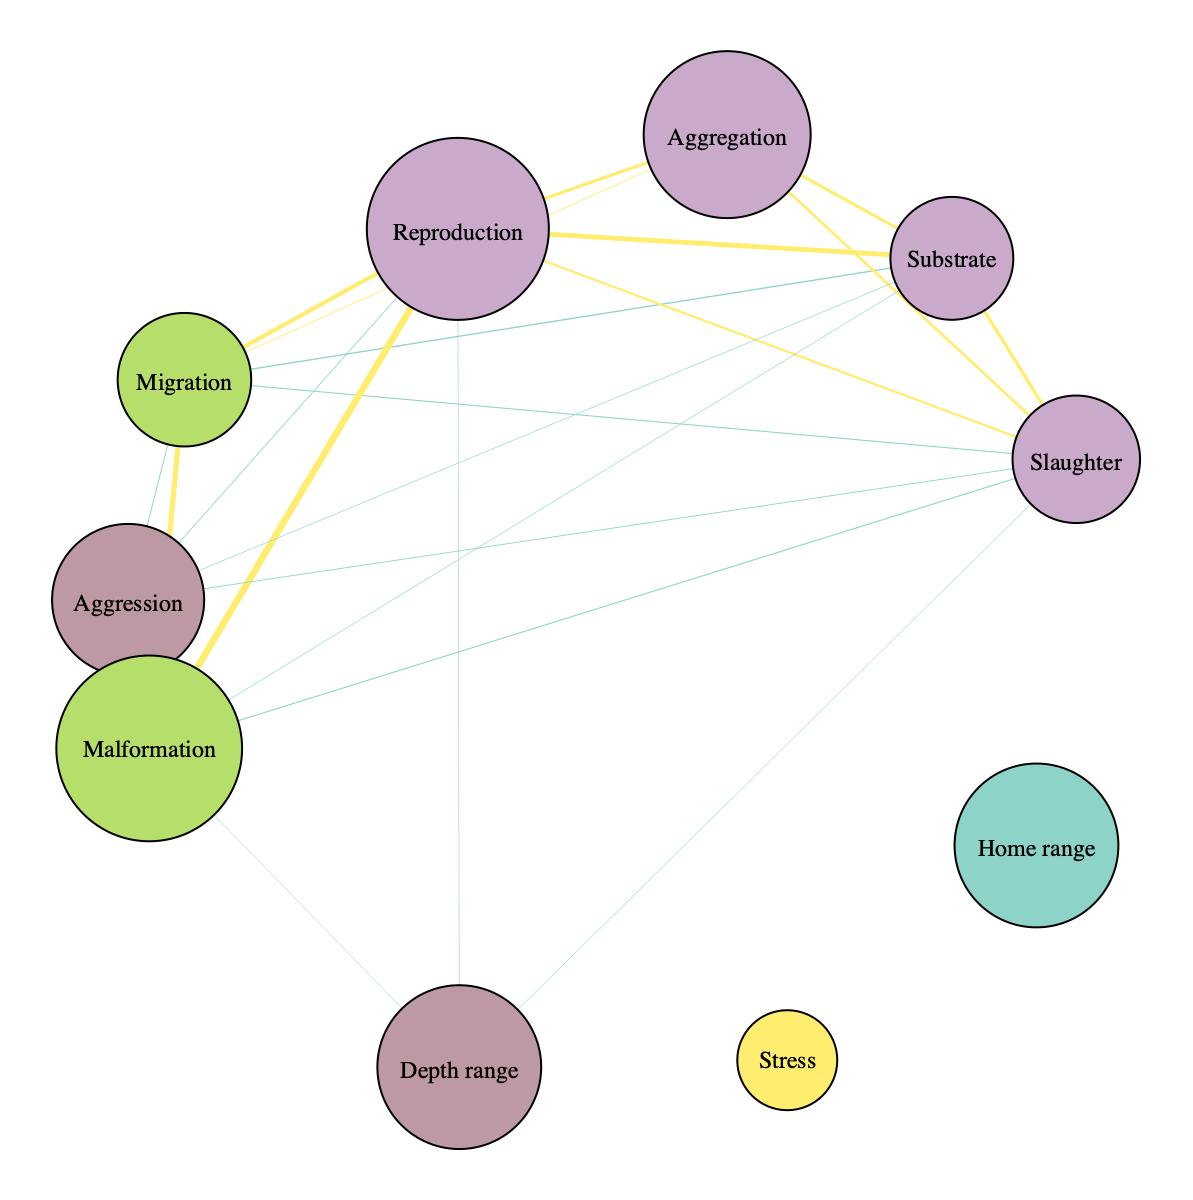

In [18]:
# visualise
pos = gt.fruchterman_reingold_layout(g, weight=weight, circular=True, n_iter=1000, a=2)

if True:
    export = False
    if export:
        impath = join(wd, metric, measure_str, 'sponge.png')
    else:
        impath = None

    gt.graph_draw(g, pos,
                  vertex_size=50, vertex_text=name, vertex_font_size=12, vertex_shape="circle",
                  vertex_text_color="black", vertex_color="black", vertex_fill_color=community,
                  vertex_pen_width=1, vertex_halo=True, vertex_halo_size=1,
                  edge_color=sign, edge_pen_width=absweight,
                  output=impath, fit_view_ink=True)